### BAGORIS Emeline & BOERSMA Hélène gr1

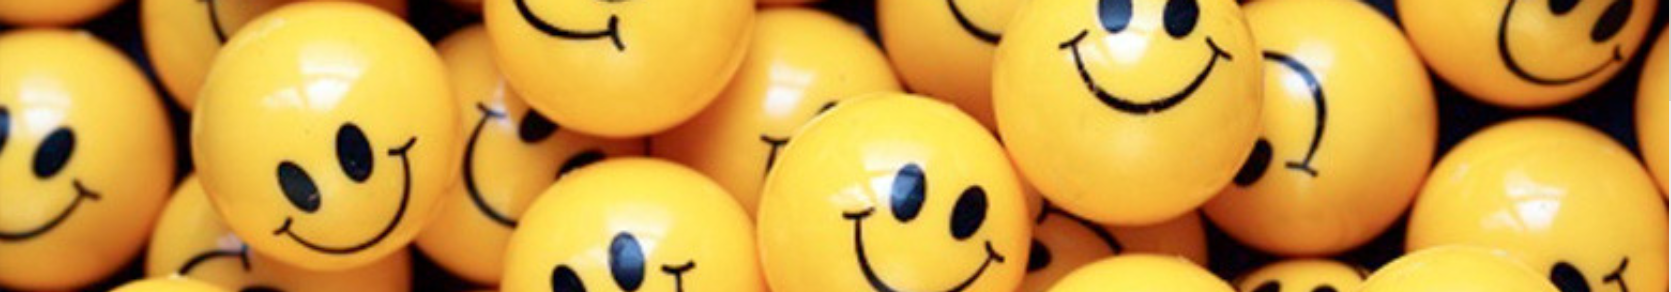

# Data visualization project : Happiness Dashboard
-------------

The World Happiness Report is a landmark survey of the state of global happiness that ranks 156 countries by how happy their citizens perceive themselves to be. Here is a fun board allowing people to explore how happiness has evolved over the past five years, with a focus on the technologies, social norms, conflicts and government policies that have driven those changes. Understanding this changes can be a way to satisfy its personal curiosity or a powerful tool for governments and social entrepreneurs to improve society.

In [1]:
#To enable video animation, open Anaconda prompt and paste : 
#conda install -c conda-forge ffmpeg

In [2]:
#pip install dash-bootstrap-components
#pip install bar_chart_race

In [3]:
import dash
import pandas as pd
import numpy as np
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import bar_chart_race as bcr

## I. Data Pre-Processing

### 1. Loading Data

We have happiness report ranging from 2015 to 2019 :

In [4]:
df2015 = pd.read_csv('2015.csv', usecols=['Country','Region','Happiness Rank','Happiness Score','Economy (GDP per Capita)','Family','Health (Life Expectancy)','Trust (Government Corruption)', 'Generosity', 'Freedom'])
df2016 = pd.read_csv('2016.csv', usecols=['Country','Region','Happiness Rank','Happiness Score','Economy (GDP per Capita)','Family','Health (Life Expectancy)','Trust (Government Corruption)', 'Generosity', 'Freedom'])
df2017 = pd.read_csv('2017.csv', usecols=['Country','Happiness.Rank','Happiness.Score','Economy..GDP.per.Capita.', 'Family', 'Health..Life.Expectancy.', 'Freedom', 'Generosity', 'Trust..Government.Corruption.'])
df2018 = pd.read_csv('2018.csv')
df2019 = pd.read_csv('2019.csv')

### 2. Merging data

The first thing we need to do in order to merge these dataframes is to select the similar columns and rename them the same :

In [5]:
df2015 = df2015.rename(columns={'Happiness Rank': 'Rank', 'Happiness Score': 'Score', 'Economy (GDP per Capita)': 'GDP per capita', 'Family': 'Social support',
'Health (Life Expectancy)' : 'Healthy life expectancy','Freedom': 'Freedom to make life choices','Trust (Government Corruption)': 'Perceptions of corruption'})

df2016 = df2016.rename(columns={'Happiness Rank': 'Rank', 'Happiness Score': 'Score', 'Economy (GDP per Capita)': 'GDP per capita', 'Family': 'Social support',
'Health (Life Expectancy)' : 'Healthy life expectancy','Freedom': 'Freedom to make life choices','Trust (Government Corruption)': 'Perceptions of corruption'})

df2017 = df2017.rename(columns={'Happiness.Rank': 'Rank', 'Happiness.Score': 'Score', 'Economy..GDP.per.Capita.': 'GDP per capita', 'Family': 'Social support',
'Health..Life.Expectancy.' : 'Healthy life expectancy','Freedom': 'Freedom to make life choices','Trust..Government.Corruption.': 'Perceptions of corruption'})

df2018 = df2018.rename(columns={'Country or region': 'Country', 'Overall rank':'Rank'})

df2019 = df2019.rename(columns={'Country or region': 'Country', 'Overall rank':'Rank'})


Then we can add a column with the year of the data and concat all those together :

In [6]:
df2015['Year'] = 2015
df2016['Year'] = 2016
df2017['Year'] = 2017
df2018['Year'] = 2018
df2019['Year'] = 2019

In [7]:
df = pd.concat([df2015, df2016, df2017, df2018, df2019])
df = df.reset_index(drop=True)
#TEST :
#mask = (df['Country'] == 'Argentina')
#print(df[mask])

### 3. Cleaning data

This dataset is very inconsistent over the years because of different spellings so we need to smooth it :

In [8]:
# Replace name of some countries

df['Country'] = df['Country'].replace(['Trinidad & Tobago'],'Trinidad and Tobago')
df['Country'] = df['Country'].replace(['Taiwan Province of China'],'Taiwan')
df['Country'] = df['Country'].replace(['Somaliland region'],'Somalia')
df['Country'] = df['Country'].replace(['Hong Kong S.A.R., China'],'Hong Kong')
df['Country'] = df['Country'].replace(['Northern Cyprus'],'North Cyprus')
df['Country'] = df['Country'].replace(['North Macedonia'],'Macedonia')

Some data is missing every year but we didn't drop such countries. 

### 4. Adding regions to countries


In [9]:
# Create a new dataframe with countries and their corresponding region
df_region = df[['Country','Region']].copy()

#drop rows with missing values
df_region = df_region.dropna()
df_region = df_region.drop_duplicates()

# Join df_region and df by country (because of missing values in df['Region'] for 2017 to 2019)

df = df.drop(columns=['Region'])
df = df.merge(df_region, on=["Country", "Country"])
df.head(3)

,Country,Rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption,Generosity,Year,Region
0,Switzerland,1,7.587,1.39651,1.349510,0.941430,0.665570,0.419780,0.296780,2015,Western Europe
1,Switzerland,2,7.509,1.52733,1.145240,0.863030,0.585570,0.412030,0.280830,2016,Western Europe
2,Switzerland,4,7.494,1.56498,1.516912,0.858131,0.620071,0.367007,0.290549,2017,Western Europe


### 5. Adding 3-letters code to countries

In order to create a map, we need to add correct 3-letters code to our countries. We are merging our dataframe with an existing csv to add the corresponding code of each country :

In [10]:
def add_country_code(year_value):
    # Filter df according to selected year
    dff_year = df[df['Year'] == year_value]

    # Merging our dataset with a dataset containing the countries' 3-letters code
    df_country = dff_year.groupby(['Country']).sum().reset_index()
    df_country.replace(0, 1, inplace=True)
    
    code_df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
    df_country_code = df_country.merge(code_df, left_on ='Country', right_on='COUNTRY', how='left')
    
    # Exception on Congo need to be handle manually according to csv creator 
    df_country_code.loc[df_country_code.Country == 'Congo (Kinshasa)', 'CODE'] = 'COD'
    df_country_code.loc[df_country_code.Country == 'Congo (Brazzaville)', 'CODE'] = 'COG'
    
    return(df_country_code)

### 6. Bar chart race dataframe format


In order to create a bar chart race, we need to transform our dataframe to fit the expected format :
- X_axis = Factor selected
- Y_axis = Country
- year evolution

In [11]:
# Function to select the top x countries according to the selected factor
def make_df_chart_race(selected, top):   
    # REDUCE RACE TO TOP 3,5,10 or directly use n_bars=x when plotting
    mask_race = df['Rank'] <= top
    
    # Special dataframe for the bar chart race 
    df_race = df[mask_race][['Country', selected, 'Year']]
    df_race = df_race.pivot(index='Year', columns='Country', values='Score')
    
    return df_race*1000 #*1000 is for styling purposes because the bar chart race automatically round data

In [12]:
make_df_chart_race('Score', 5)
# NaN is totally normal because they were out of the top selected that year

Country,Canada,Denmark,Finland,Iceland,Netherlands,Norway,Switzerland
Year,,,,,,,
2015,7427.0,7527.000000,NaN,7561.000000,NaN,7522.000000,7587.000000
2016,NaN,7526.000000,7413.000000,7501.000000,NaN,7498.000000,7509.000000
2017,NaN,7521.999836,7468.999863,7504.000187,NaN,7537.000179,7493.999958
2018,NaN,7555.000000,7632.000000,7495.000000,NaN,7594.000000,7487.000000
2019,NaN,7600.000000,7769.000000,7494.000000,7488.0,7554.000000,NaN


### X. Useful variables

In [13]:
all_regions = df.Region.unique()
#all_regions

In [14]:
all_countries = df.Country.unique()
#all_countries

## II. App building

In [15]:
external_stylesheets=[dbc.themes.BOOTSTRAP]
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

### 1. Layout elements

#### *Map panel*

This is the layout of the control panel of the map :
- Title/Presentation of the dashboard
- Dropdown to select factor of influence
- Slider to select year

In [16]:
controlsMap = dbc.Card(
    [
        html.H1("Happiness Dashboard"),
        html.Hr(),
        html.P(
        """ The World Happiness Report is a landmark survey of the state of global happiness that ranks 156 countries 
        by how happy their citizens perceive themselves to be. Try and explore the dashboard to discover which
        factor influence happiness !"""),
        
        dbc.FormGroup(
            [
                dbc.Label("Select factor of influence"),
                dcc.Dropdown(id="value-selected", 
                             options=[{"label": col, "value": col} for col in df.columns[2:9]],
                             value='Score', #default value
                ),
            ]
        ),
        dbc.FormGroup(
            [
                dbc.Label("Select year"),
                dcc.Slider(
                    id='year-slider',
                    min=df['Year'].min(),
                    max=df['Year'].max(),
                    value=df['Year'].min(),
                    marks={str(year): str(year) for year in df['Year'].unique()},
                    step=None
                )
            ]
        ),
    ],
    body=True,
    style={'box-shadow': '2px 2px 2px lightgrey'},
    #style={'backgroundColor': colors['background']}
)

Here we are agencing every element related to the map in the first row :
- On the left side : panel controls for user
- On the right side : map

In [17]:
row1 = dbc.Row([
                dbc.Col(controlsMap, width=4),
                dbc.Col(dbc.Card([
                        #html.H4("MAP"),
                        dcc.Graph(id="map-graph")], 
                    style={'box-shadow': '2px 2px 2px lightgrey'}
                ), 
                    width=8,),
                ],
               align="center",
               #style={'backgroundColor': colors['background']}
               )

#### *Rank panel* 

In [18]:
fig_race = bcr.bar_chart_race(make_df_chart_race('Score', 10),
                              #filename='chart_race.mp4',
                              n_bars=5, 
                              period_length=3000,
                              figsize=(5, 3),
                              period_label={'x': .99, 'y': 0, 'ha': 'right', 'color': 'red'},
                              title='Happiness score by Country',
                              title_size='smaller',
                              cmap= 'Set3',#'prism',
                              filter_column_colors=True, #Avoir repeating colors
                             )

fig_race

C:\Users\Emeline\anaconda3\lib\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
C:\Users\Emeline\anaconda3\lib\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


In [19]:
row2 = dbc.Row([
                  dbc.Col(
                      dbc.Card([
                              html.P(""" """),                           
                              html.Div(id = 'race_chart'), 
                              html.P(""" """)                           
                              ],
                              style={'box-shadow': '2px 2px 2px lightgrey', 'margin-top':15}
                    ), width=4),
    
                  dbc.Col(
                      dbc.Card([
                              html.H4("Overall factor rank of countries per year"),
                              dcc.Graph(id="rank-graph")
                              ], 
                              style={'box-shadow': '2px 2px 2px lightgrey', 'margin-top':15},
                              body=True,
                 ), width=8,),
    
        ], align="stretch") 

#### *Country pie panel*

In [20]:
pieCard = dbc.Card([
                    html.H4("Factor impact per country", style={'color': '#f08080'}),
                    dbc.FormGroup([
                        dbc.Label("Select country"),
                        dcc.Dropdown(id='dropdown_country',
                                     value=all_countries[0],
                                     options=[{"label": x, "value": x} for x in all_countries],
                                     clearable=False)
                    ]),
                    dcc.Graph(id="pie-chart"),
    ],
    body=True,
    style={'box-shadow': '2px 2px 2px lightgrey',
           'margin-top':15},
)


#### *Factor correlation panel*

In [21]:
print('Factors list used for the correlation :')
for col in df.columns[4:9]:
    print('-',col)

Factors list used for the correlation :
- Social support
- Healthy life expectancy
- Freedom to make life choices
- Perceptions of corruption
- Generosity


In [22]:
controlsCorr = dbc.Card(
    [
        dbc.FormGroup(
            [
                dbc.Label("X variable"),
                dcc.Dropdown(
                    id="x-variable",
                    options=[{"label": col, "value": col} for col in df.columns[3:9]],
                    value="GDP per capita",
                ),
            ]
        ),
        dbc.FormGroup(
            [
                dbc.Label("Y variable"),
                dcc.Dropdown(
                    id="y-variable",
                    options=[{"label": col, "value": col} for col in df.columns[3:9]],
                    value="Generosity",
                ),
            ]
        ),
        dbc.FormGroup(
            [
                dbc.Label("Cluster count"),
                dbc.Input(id="cluster-count", type="number", value=3, min=1, max=5),
            ]
        ),
    ],
    body=True,
    style={'margin-top':30}
)


In [23]:
corrCard = dbc.Card([
                dbc.Row([
                    dbc.Col([
                        html.H4("Factor correlation", style={'color': '#f08080'}),
                        controlsCorr], width=4),
                    dbc.Col(dcc.Graph(id="cluster-graph"))], align="stretch"), ], 
                body=True,
                style={'box-shadow': '2px 2px 2px lightgrey', 'margin-top':15}
    
    )

In [24]:
figScatter = px.scatter(x=df['GDP per capita'],y=df['Generosity'])

In [25]:
row3 = dbc.Row([
                dbc.Col(pieCard, width=4),
                dbc.Col(corrCard, width=8),
               ],
               align="stretch"
)

#### *Simple Factor plot panel*

In [26]:
row4 = dbc.Row([
                html.H4("Factor evolution per region", style={'color': '#f08080'}),

                dbc.FormGroup(
                [
                    dbc.Label("Select region"),
                        dcc.Checklist(
                            id="checklist",
                            options=[{"label": x, "value": x} for x in all_regions],
                            value=all_regions[:1],
                            labelStyle={'display': 'table-cell'}
                        )
                ],),

                    dbc.Col(dcc.Graph(id="line-chart"), width=6),
                    dbc.Col(dcc.Graph(id="line-chart2"), width=6),
                    ], 
                   align="center",
                   )

### 2. Layout with bootstrap

In [27]:
app.layout = dbc.Container(
    [
        row1,
        row2,
        row3,
        dbc.Card(row4,body=True,style={'box-shadow': '2px 2px 2px lightgrey', 'margin-top':15}),
    ],
    fluid=True,
    style={'backgroundColor':'#F9F9F9',
        'padding': 15}
)

### 3. Callback

#### *Map behaviour*

In [28]:
## Define the values displayed by the map according to the year and factor selection of the user
@app.callback(
    Output('map-graph', 'figure'),
    [Input('value-selected', 'value'),
     Input('year-slider', 'value')])

def update_map(selected,year_value):
    # Get a dataframe with 3-letters code per country
    dff = add_country_code(year_value)
    
    # Define the legend displayed on hover
    dff['hover_text'] = dff["Country"] + ": " + dff[selected].apply(str)

    # Create the choropleth (colored map)
    trace = go.Choropleth(locations=dff['CODE'],z=np.log(dff[selected]),
                          text=dff['hover_text'],
                          hoverinfo="text",
                          marker_line_color='white',
                          autocolorscale=False,
                          reversescale=True,
                          colorscale="RdBu",marker={'line': {'color': 'rgb(180,180,180)','width': 0.5}},
                          colorbar={"thickness": 10,"len": 0.3,"x": 0.9,"y": 0.7,
                                    'title': {"text": selected, "side": "bottom"},
                                    'tickvals': [dff[selected].min(), dff[selected].max()],
                                   })   
    
    # Return figure data + figure layout
    return {"data": [trace],
            "layout": go.Layout(height=410,
                                width=900,
                                margin={"r":0,"t":0,"l":0,"b":0}, 
                                autosize=True, 
                                geo={'showframe': False,'showcoastlines': False,'projection': {'type': "miller"}})}

#### *Line chart behaviour*

In [29]:
@app.callback(
    Output("line-chart", "figure"), 
    [Input("checklist", "value")])

def update_line_chart(regions):
    mask = df.Region.isin(regions)
    dff = df[mask].groupby(['Year', 'Region']).mean()
    dff = dff.reset_index()
    fig = px.line(dff, x='Year', y='Healthy life expectancy', color='Region')
    
    return fig


In [30]:
@app.callback(
    Output("line-chart2", "figure"), 
    [Input("checklist", "value")])

def update_line_chart(regions):
    mask = df.Region.isin(regions)
    dff = df[mask].groupby(['Year', 'Region']).mean()
    dff = dff.reset_index()

    fig = px.line(dff, x='Year', y='GDP per capita', color='Region')

    return fig

#### *Rank histogram behaviour*

In [31]:
@app.callback(
    Output("rank-graph", "figure"), 
    [Input('value-selected', 'value'),
     Input('year-slider', 'value')])

def generate_chart(selected,year):
    mask = (df['Year']==year)
    dff = df[mask]
    fig = px.bar(dff, x='Country', y=selected)
    fig.update_layout(uniformtext_minsize=6, 
                      uniformtext_mode='hide', 
                      height=375,
                      margin=dict(t=10,b=0,l=0,r=0),
                     )
    fig.update_xaxes(tickangle = 45)
    return fig
                    

#### *Pie chart behaviour*

In [32]:
@app.callback(
    Output("pie-chart", "figure"), 
    [Input("dropdown_country", "value"),
    Input('year-slider', 'value')]
)

def generate_chart(country,year):
    mask = ((df['Country']==country) & (df['Year']==year))
    dff = df[mask]

    names = ['GDP per capita', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity', 'Social support', 'Healthy life expectancy']
    val = [dff['GDP per capita'].values[0], dff['Freedom to make life choices'].values[0], dff['Perceptions of corruption'].values[0], dff['Generosity'].values[0], dff['Social support'].values[0], dff['Healthy life expectancy'].values[0]]

    fig = px.pie(df[mask], values=val, names=names,  title='Proportion of each factor', hole=.3)
    fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

    return fig


#### *Correlation graph behaviour*

In [33]:
@app.callback(
    Output("cluster-graph", "figure"),
    [
        Input('year-slider', 'value'),
        Input("x-variable", "value"),
        Input("y-variable", "value"),
        Input("cluster-count", "value"),
    ],
)
def make_graph(year, fx, fy, n_clusters):
    # Select our 2 factors (fx, fy) in dataframe according to year
    mask = (df['Year']==year)
    dff = df[mask]
    df_corr = dff.loc[:, [fx, fy]] # chained indexing dff.loc[[fx, fy]] produce warning so we used double indexing !
    
    # Initialize model with the number of clusters to form and fit values
    km = KMeans(n_clusters) 
    km.fit(df_corr.values)
    
    # Get clustering results 
    df_corr["cluster"] = km.labels_
    centers = km.cluster_centers_
    
    # Add countries since clustering is done
    df_corr['Country'] = dff['Country']

    # Create the scatter plot with the cluster as colors
    data = [
        go.Scatter(
            x=df_corr.loc[df_corr.cluster == c, fx],
            y=df_corr.loc[df_corr.cluster == c, fy],
            mode="markers", #little dot
            marker={"size": 8},
            hovertext= df_corr.loc[df_corr.cluster == c, 'Country'], 
            name="Cluster {}".format(c),
        )
        for c in range(n_clusters)
    ]

    # Add the cluster centers to the scatter plot
    data.append(
        go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            mode="markers", #little dot
            marker={"color": "#000", "size": 12, "symbol": "diamond"},
            name="Cluster centers",
        )
    )

    layout = {"title": "Clustering factors with K-means", "xaxis": {"title": fx}, "yaxis": {"title": fy},}

    return go.Figure(data=data, layout=layout)

#### *Bar chart race behaviour*

In [34]:
@app.callback(
    Output("race_chart", "children"), 
    [Input('value-selected', 'value')]
)

def select_gif(factor):
    if (factor == 'GDP per capita'):
        source = 'https://media.giphy.com/media/Fz18sll0oV1cAoIKh6/giphy.mp4'
    if (factor == 'Score'):
        source = 'https://media.giphy.com/media/SGTD5KxRctJ1WeOnZ6/giphy.mp4'
    if (factor == 'Social support'):
        source = 'https://media.giphy.com/media/LlZJliVyHFdnZccWzQ/giphy.mp4'
    if (factor == 'Healthy life expectancy'):
        source = 'https://media.giphy.com/media/LrB8ljhGzinwf1X13i/giphy.mp4'
    if (factor == 'Freedom to make life choices'):
        source = 'https://media.giphy.com/media/pjafPnOglhMuCEZdt5/giphy.mp4'
    if (factor == 'Perceptions of corruption'):
        source = 'https://media.giphy.com/media/sVCSTGlUmfxHt2Ju15/giphy.mp4'
    if (factor == 'Generosity'):
        source = 'https://media.giphy.com/media/Gec2O8FrmBs0HqBXaW/giphy.mp4'
    
    video = html.Video(
            controls = True,
            id = 'race_chartz',
            src = source,
            autoPlay=True
        )
    
    return video
 

## III. Happy dashboard :)

In [35]:
# Run app and display result on http://127.0.0.1:8050/
app.run_server(debug=True, use_reloader=False)

Dash app running on http://127.0.0.1:8050/
